#  Running AOS on AuxTel - main points

I find on which night defocal exposures were taken from the Observers Log, eg. https://confluence.lsstcorp.org/display/LSSTCOM/2021-06-08+Aux-Tel+Night+Log
    

Find dataset refs for these observations:

In [2]:
from lsst.daf import butler as dafButler
butler = dafButler.Butler('/repo/main/')

In [3]:
registry = butler.registry
datasetRefs = list(registry.queryDatasets(instrument='LATISS', datasetType='raw', collections=['LATISS/raw/all'],
                                          where="exposure.day_obs=20210608"
                                         ))
datasetRefs[0]

DatasetRef(DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure), {instrument: 'LATISS', detector: 0, exposure: 2021060800001, ...}, id=bfad0366-9915-5a37-b6f0-d42752929172, run='LATISS/raw/all')

I pick one intra - 2021060800400 and one extra - 2021060800401 exposure.

Show the raw exposures. Print `FOCUSZ` to show the offset:

In [4]:
from lsst.daf import butler as dafButler
butler = dafButler.Butler('/repo/main/', instrument='LATISS')
exposure_intra = butler.get('raw', dataId={'instrument':'LATISS', 'detector':0, 
                                     'exposure':2021060800400},
                      collections=['LATISS/raw/all'])
print(exposure_intra.getMetadata()['FOCUSZ'])

exposure_extra = butler.get('raw', dataId={'instrument':'LATISS', 'detector':0, 
                                     'exposure':2021060800401},
                      collections=['LATISS/raw/all'])

print(exposure_extra.getMetadata()['FOCUSZ'])



/lsstdata/offline/instrument/LATISS/storage/2021-06-08/AT_O_20210608_000400-R00S00.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))


-0.770438730716705


/lsstdata/offline/instrument/LATISS/storage/2021-06-08/AT_O_20210608_000401-R00S00.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))


0.829561293125153


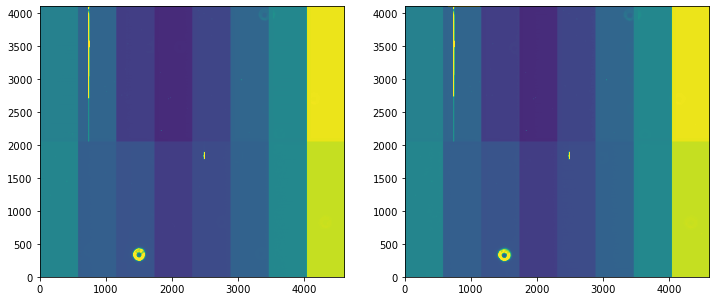

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
fig,ax  = plt.subplots(1,2,figsize=(12, 10))
ax[0].imshow(exposure_extra.image.array, origin='lower',vmax=20000)# vmax=50)
mappable = ax[1].imshow(exposure_intra.image.array, origin='lower',vmax=20000)
#plt.colorbar(mappable,ax=ax[1])

Run the ISR : 

    pipetask run  --data-query "exposure IN (2021060800400,2021060800401) AND instrument='LATISS' " -b /repo/main/butler.yaml --input  LATISS/raw/all,LATISS/calib,u/czw/DM-28920/calib.20210720  --output u/scichris/Latiss/postISR11 --pipeline /project/scichris/aos/testLatiss4.yaml  --register-dataset-types

Where the config yaml contained 

    isr:
        class: lsst.ip.isr.isrTask.IsrTask
        config:
          connections.outputExposure: postISRCCD
          doApplyGains: false
          doBias: true
          doBrighterFatter: false
          doCrosstalk: false
          doDark: true
          doDefect: false
          doFlat: true
          doFringe: true
          doInterpolate: true
          doLinearize: false
          doNanMasking: false
          doOverscan: true
          doVariance: false
          python: OverscanCorrectionTask.ConfigClass.fitType = 'MEDIAN_PER_ROW'

Show the postISR : 

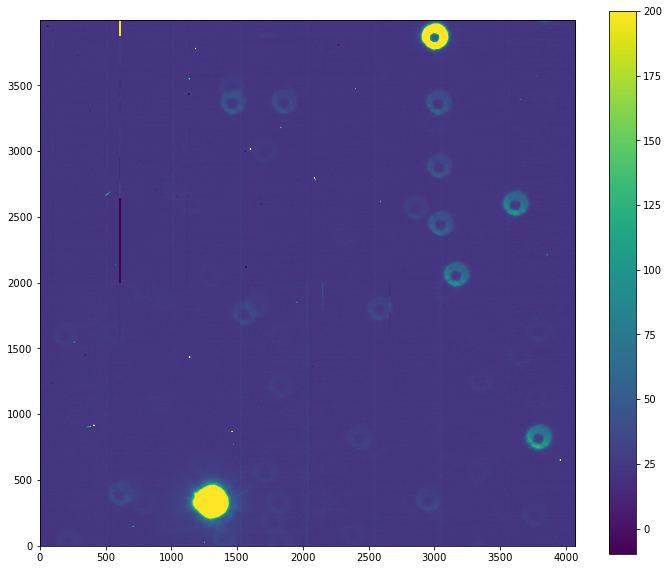

In [6]:
%matplotlib inline
from astropy.io import fits
hdula = fits.open('/repo/main/u/scichris/Latiss/postISR11/\
20210901T225749Z/postISRCCD/20210608/AT_O_20210608_000400/\
postISRCCD_LATISS_RG610~empty_AT_O_20210608_000400_RXX_S00_u_scichris_Latiss_postISR11_20210901T225749Z.fits'
                 )
fig = plt.figure(figsize=(12, 10))
plt.imshow(hdula[1].data, origin='lower',vmin=-10,vmax=200)
plt.colorbar()

### Running the Zernike Estimation

Figure out what refs are available for the `postISR` image  from the butler :

In [8]:
from lsst.daf import butler as dafButler
instrument = 'LATISS'
dataId0 = dict(instrument=instrument)
repo_dir = '/repo/main/'
butler = dafButler.Butler(repo_dir, collections=['run1'])
                          
dataset = next(iter(
                butler.registry.queryDatasets(
                    datasetType='postISRCCD', 
                    collections=['u/scichris/Latiss/postISR11'],
                    dataId=dataId0  )
                )
           )

expN = dataset.dataId["exposure"]

# Get the refs  for this dataset
refs = []
for ref in butler.registry.queryDatasets(
                    datasetType='postISRCCD', 
                    collections=['u/scichris/Latiss/postISR11'],
                    dataId=dataId0  ):
    refs.append(ref)

In [9]:
refs[0].dataId

{instrument: 'LATISS', detector: 0, exposure: 2021060800400, ...}

Read in the two  postISR exposures - one is intra, the other extra-focal, but we don't need to know as the code will figure it out based on `FOCUSZ`:

In [10]:
exp1 = butler.get(datasetRefOrType='postISRCCD',dataId=refs[0].dataId,
              collections=['u/scichris/Latiss/postISR11'])

exp2 = butler.get(datasetRefOrType='postISRCCD',dataId=refs[1].dataId,
              collections=['u/scichris/Latiss/postISR11'])

# %matplotlib inline
# import matplotlib.pyplot as plt
# fig,ax = plt.subplots(1,2,figsize=(10,5))
# ax[0].imshow(exp1.image.array, origin='lower', vmin=-10,vmax=200)
# ax[1].imshow(exp2.image.array, origin='lower', vmin=-10,vmax=200)

Store as an exposure pair passed to `ts_wep` : 

In [11]:
expPair = [exp1,exp2]

### Get the donut template

Use a larger stamp size due to larger AuxTel donuts compared to LSSTCam

In [15]:
from lsst.ts.wep.task.EstimateZernikesLatissTask import EstimateZernikesLatissTask, EstimateZernikesLatissTaskConfig
estimateZernikeConfig = EstimateZernikesLatissTaskConfig(donutStampSize=200,donutTemplateSize=200)
estimateZernikeTask = EstimateZernikesLatissTask(config=estimateZernikeConfig)
estimateZernikeTask.instName = 'auxTel'
estimateZernikeTask.opticalModel = 'onAxis'

Show the template:

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
from lsst.ts.wep.Utility import DefocalType

# get the defocal exposure...
from lsst.daf import butler as dafButler
butler = dafButler.Butler('/repo/main/', collections=['u/scichris/Latiss/postISR11'])
exposure  = butler.get(datasetRefOrType='postISRCCD',
                       dataId={'detector':"RXX_S00",'exposure':2021060800401})


# make template 
detectorName = exposure.getDetector().getName()
pixelScale = exposure.getWcs().getPixelScale().asArcseconds()
defocalType = DefocalType.Extra
template = estimateZernikeTask.getTemplate(detectorName, defocalType, pixelScale)

In DonutTemplateModel using opticalModel onAxis
and maskScalingFactorLocal=2.0
apertureDiameter=1.2, focalLength=21.6
offset=0.0475
maskScalingFactorLocal=2.0

 rMask:
0.0026388888888888885


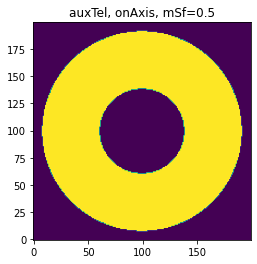

In [18]:
plt.imshow(template,origin='lower')
plt.title(f'auxTel, {estimateZernikeTask.opticalModel}, mSf=0.5')
plt.savefig(f'auxTel_{estimateZernikeTask.opticalModel}_maskScalingFactorLocal-05.png')

Detect the donuts:

In [19]:
from lsst.ts.wep.DonutDetector import DonutDetector
detector = DonutDetector()

from copy import copy
expArray = copy(exposure.getImage().getArray())

# this is to make sure that oversaturated pixels do not 
# confuse the image range 
expArray[expArray < 0] = 0
expArray[expArray > 50] = 50

donutDf = detector.detectDonuts(expArray,template,blendRadius=100,
                               peakThreshold=0.9)

In [61]:
donutDf

,x_center,y_center,blended,blended_with,num_blended_neighbors
0,289,1311,False,None,0
1,3867,2993,False,None,0
2,830,3783,False,None,0
3,2601,3607,False,None,0
4,2065,3156,False,None,0
5,2449,3038,False,None,0
6,3367,3022,False,None,0
7,3371,1459,False,None,0


Make a donut catalog, which needs a coordinate column, and different names for columns

In [20]:
# need  to rename columns 
# as we EstimateZernikes 
# expects different names 
#Unnamed: 0	coord_ra	coord_dec	centroid_x	centroid_y	source_flux	detector	mags
donutCat = donutDf.copy()

# also, need to transpose y--> x 
donutCat = donutCat.rename(columns={"y_center":"centroid_x", "x_center":"centroid_y"})

In [21]:
donutCat['detector'] = "RXX_S00"

In [22]:
donutCat

,centroid_y,centroid_x,blended,blended_with,num_blended_neighbors,detector
0,289,1311,False,None,0,RXX_S00
1,3867,2993,False,None,0,RXX_S00
2,830,3783,False,None,0,RXX_S00
3,2601,3607,False,None,0,RXX_S00
4,2065,3156,False,None,0,RXX_S00
5,2449,3038,False,None,0,RXX_S00
6,3367,3022,False,None,0,RXX_S00
7,3371,1459,False,None,0,RXX_S00


Plot the detected donuts on top of the exposure

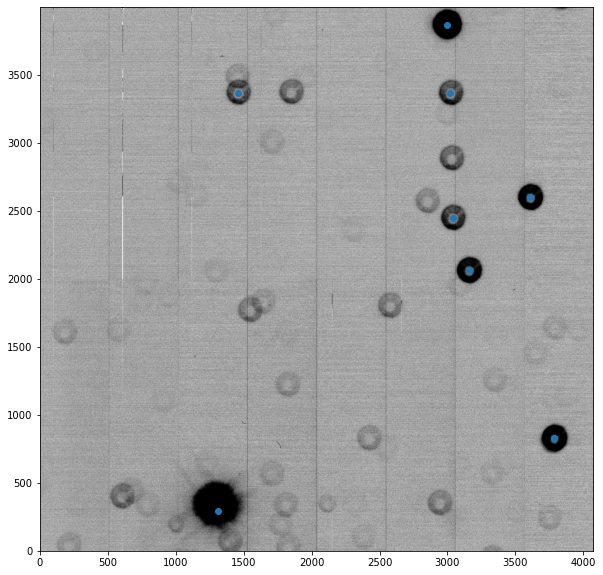

In [23]:
from astropy.visualization import ZScaleInterval
data = expArray
zscale = ZScaleInterval()
vmin, vmax = zscale.get_limits(data)

fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(data, vmin=vmin, vmax=vmax,cmap='Greys', origin='lower')
ax.scatter(donutDf['y_center'], donutDf['x_center'])

#ax.imshow(template,alpha=0.1)

Try to get any ra,dec in radians, even based on an incorrect WCS, to pass to `cutoutStamps`:

In [25]:
wcs = exposure.getWcs()

import numpy as np 
x = np.array(donutCat['centroid_x'].values)
y = np.array(donutCat['centroid_y'].values)

x = np.zeros(0)
for row in donutCat['centroid_x'] : 
    x = np.append(x, row)
    
ra,dec = wcs.pixelToSkyArray(x,y,degrees=False)  

donutCat['coord_ra'] = ra
donutCat['coord_dec'] = dec

Run the Zernike estimation given the exposure pair and the donut catalog

In [ ]:
# This should return the extra-focal DonutStamps, intra-focal DonutStamps and
# Zernike coefficient numpy array as Struct that can be saved to
# Gen 3 repository all with the same dataId.
zernikeOutput = estimateZernikeTask.run(expPair, donutCat, "LATISS")

In DonutTemplateModel using opticalModel onAxis
and maskScalingFactorLocal=2.0
apertureDiameter=1.2, focalLength=21.6
offset=0.0475
maskScalingFactorLocal=2.0

 rMask:
0.0026388888888888885
In DonutTemplateModel using opticalModel onAxis
and maskScalingFactorLocal=2.0
apertureDiameter=1.2, focalLength=21.6
offset=0.0475
maskScalingFactorLocal=2.0

 rMask:
0.0026388888888888885
0 / 8
apertureDiameter=1.2, focalLength=21.6
offset=0.0475
maskScalingFactorLocal=1

 rMask:
0.0013194444444444443
apertureDiameter=1.2, focalLength=21.6
offset=0.0475
maskScalingFactorLocal=1

 rMask:
0.0013194444444444443
imageCoCenter: (x, y) = (   74.53,   96.65)

imageCoCenter: (x, y) = (   75.61,   89.98)

itr = 0, z4-z22
[ -15.  -64.  -67. -135. -428.  -13.  104.    2.    5.    8.    3.   13.
  111.   25.  -11.    1.    1.   -7.    3.]
itr = 1, z4-z22
[ -23.  -88.  -75. -135. -412.  -16.  126.    2.    5.   12.   -1.   14.
  115.   27.  -11.    1.    7.   -8.    3.]
itr = 2, z4-z22
[ -32. -140.  -79. -134.

itr = 5, z4-z22
[165. 113.  86. -32. -82.  -5. 133.  -5. -33. -15. -14.  -1.  10.   1.
  -7.   5.   2.  -1.  -4.]
itr = 6, z4-z22
[ 172.   80.   31.  -50. -152.   -8.  154.   -6.  -27.  -10.  -12.   -1.
   28.    6.   -5.    3.    3.   -0.   -3.]
itr = 7, z4-z22
[ 167.   62.   -6.  -47. -130.  -13.  158.   -3.  -22.   -7.   -9.   -0.
   16.    2.   -2.    3.    2.    0.   -3.]
itr = 8, z4-z22
[ 166.   47.  -23.  -49. -144.  -17.  158.   -1.  -17.   -3.   -4.    1.
   16.    2.   -2.    2.    1.    0.   -3.]
itr = 9, z4-z22
[ 158.   44.  -29.  -53. -177.  -14.  156.   -2.  -15.   -2.   -5.    2.
   25.    2.   -2.    1.    1.    0.   -2.]
itr = 10, z4-z22
[ 149.   36.  -29.  -52. -186.  -13.  153.   -1.  -13.    0.   -4.    3.
   27.    2.   -3.    1.    0.    0.   -2.]
itr = 11, z4-z22
[ 146.   38.  -22.  -53. -190.  -13.  148.   -2.  -12.    1.   -3.    5.
   26.    2.   -3.    1.   -0.   -0.   -2.]
itr = 12, z4-z22
[ 141.   34.  -11.  -52. -188.  -15.  143.   -2.  -11.    2.   -1.   

Explore the results

In [103]:
zernikeOutput.outputZernikesRaw[7]


array([-0.01540499, -0.06160212, -0.10774781, -0.01256586,  0.03333587,
       -0.04307701,  0.05463733, -0.00404744,  0.00318675,  0.00304737,
        0.00830958,  0.00918287, -0.02538812, -0.00513388,  0.00068482,
       -0.00326566,  0.04342801,  0.00227987,  0.0020678 ])

In [87]:
zerCoeff = zernikeOutput.outputZernikesAvg

In [98]:
zerCoeff

array([ 2.47260417e-02, -7.32795073e-02, -8.76606725e-02, -4.26394748e-02,
       -1.46299205e-01, -3.64879912e-02,  5.83223837e-02, -8.44319061e-04,
        2.12073857e-03,  7.91765445e-03,  1.12707021e-02,  1.04426167e-02,
        2.65352092e-03, -2.42262088e-03, -4.06450768e-03, -1.05796670e-04,
        5.16120256e-03, -1.81081416e-04,  1.98741789e-03])

Plot the Zernike coefficients:

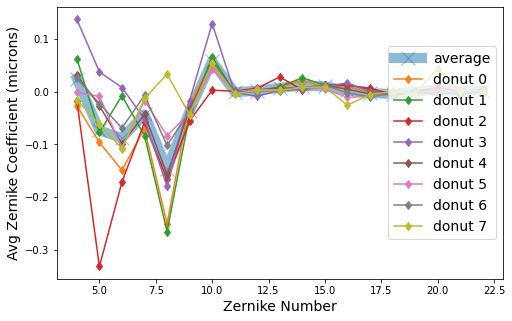

In [124]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(8, 5))
# I'm not sure about the OPD values to compare to... 
#plt.plot(np.arange(4, 23), opdVals[85], '-o', lw=3, markersize=10, label='OPD')
plt.plot(np.arange(4, 23),  zernikeOutput.outputZernikesAvg, '-x', lw=10,alpha=0.5, markersize=14, label='average')
for i in [0,1,2,3,4,5,6,7]:
    plt.plot(np.arange(4, 23),zernikeOutput.outputZernikesRaw[i], '-d', label=f'donut {i}')
    plt.xlabel('Zernike Number', size=14)
    plt.ylabel('Avg Zernike Coefficient (microns)', size=14)
plt.legend(fontsize=14, loc='center right')

Plot the donut stamps 

Text(0.5, 1.0, 'Intra')

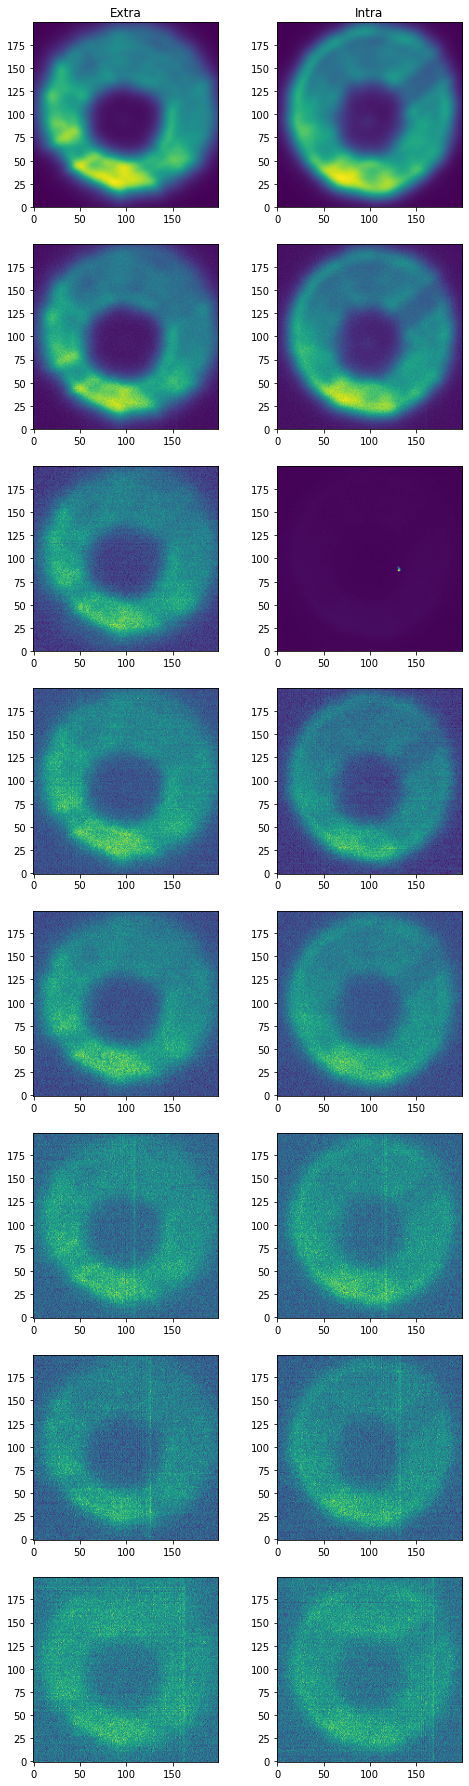

In [118]:
fig,ax = plt.subplots(8,2,figsize=(8,4*8))

for i in range(len(zernikeOutput.donutStampsExtra)):
    donut = zernikeOutput.donutStampsExtra[i]
    ax[i,0].imshow(donut.stamp_im.getArrays()[0], origin='lower')
    
    donut = zernikeOutput.donutStampsIntra[i]
    ax[i,1].imshow(donut.stamp_im.getArrays()[0], origin='lower')
ax[0,0].set_title('Extra')
ax[0,1].set_title('Intra')